# QBUS6830 Tutorial Lab 9: ARCH and GARCH Models  (ctd)
## Data
In this lab session we will use daily data on BHP returns, from Jan, 2000 to July, 2021. The data can be found in the file `bhp_yf_2000_2021.csv`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from datetime import datetime
import yfinance as yf
import os
from scipy.stats import kurtosis
from statsmodels.tsa.arima.model import ARIMA
from tqdm.notebook import tqdm
from statsmodels.stats.stattools import jarque_bera
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch

In [2]:
name_bhp = 'bhp_yf_2000_2021.csv'
data_bhp = yf.download("BHP.AX", start='2000-01-01', end='2021-07-20')
data_bhp.to_csv(name_bhp)

[*********************100%***********************]  1 of 1 completed


#### (a) Transform the prices to percentage log-returns. Plot the prices and return series.

In [3]:
p = data_bhp['Adj Close']
r = 100 * np.log(p).diff().dropna()

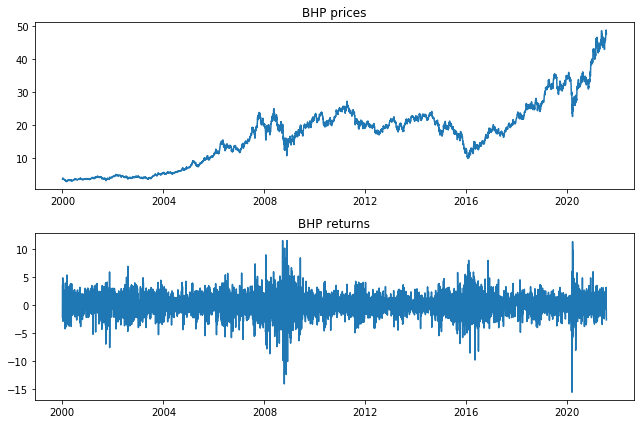

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(9, 6))
ax[0].plot(p)
ax[0].set_title('BHP prices')
ax[1].plot(r)
ax[1].set_title('BHP returns')
plt.tight_layout()
plt.show()

#### (b) Is there evidence of ARCH effects in the log-returns? Use an ACF plot and the Ljung-Box and Engle's ARCH tests with 5 and 10 lags and 5% significance level to answer the question.

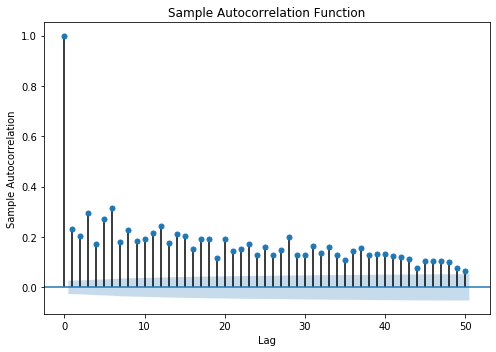

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sm.graphics.tsa.plot_acf(r**2, lags=50, alpha=0.05, ax=ax)
plt.xlabel('Lag')
plt.ylabel('Sample Autocorrelation')
plt.title('Sample Autocorrelation Function')
plt.tight_layout()
plt.show()

In [6]:
# Null Hypothesis - The data are independently distributed
acorr_ljungbox(r**2, lags=5, model_df=1, return_df=True).iloc[-1]

lb_stat      1561.061027
lb_pvalue       0.000000
Name: 5, dtype: float64

In [7]:
acorr_ljungbox(r**2, lags=10, model_df=1, return_df=True).iloc[-1]

lb_stat      2955.037536
lb_pvalue       0.000000
Name: 10, dtype: float64

In [8]:
# Null Hypothesis - A series of residuals (rt) exhibits no conditional heteroscedasticity (ARCH effects)

arch_stat, pval = het_arch(r, nlags=5)[:2]
print(arch_stat)
print(pval)

872.6127434498161
2.249539895269748e-186


In [9]:
arch_stat, pval = het_arch(r, nlags=10)[:2]
print(arch_stat)
print(pval)

1073.4347425412266
2.8094504418103335e-224


### Answer guide
The ACF of the squared returns shows moderately strong positive correlations for most of the lags 1-20 shown; the ACF is dying down but at a slow rate. This indicates ARCH effects in the BHP returns. The Ljung-Box tests using the first 5 and 10 lags conform that these ARCH effects are statistically significant (p-val $\approx 0$), i.e. both the 1st 5 and 1st 10 lags of autocorrelation include at least 1 correlation that is significantly different to 0. Engle's ARCH test gives the equivalent results. These all indicate strong, statistically significant ARCH effects in the BHP returns.

#### (c) Fit a constant mean Student-t error ARCH(1) model to the return data using ML. Report and interpret the parameter estimates and plot the estimated conditional volatility series.

In [10]:
arch1t = arch_model(r, mean='Constant', vol='ARCH', dist='StudentsT', p=1)

arch1t_fit = arch1t.fit(disp="off")
print(arch1t_fit.summary())

                         Constant Mean - ARCH Model Results                         
Dep. Variable:                    Adj Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             ARCH   Log-Likelihood:               -10866.3
Distribution:      Standardized Student's t   AIC:                           21740.5
Method:                  Maximum Likelihood   BIC:                           21767.0
                                              No. Observations:                 5450
Date:                      Fri, Oct 15 2021   Df Residuals:                     5449
Time:                              12:01:44   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

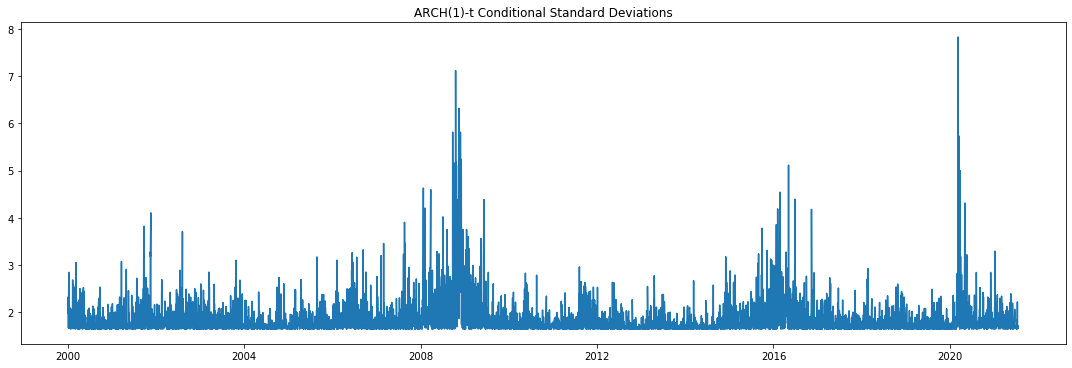

In [11]:
s = arch1t_fit.conditional_volatility
plt.figure(figsize=(15, 5))
plt.plot(s)
plt.tight_layout()
plt.title('ARCH(1)-t Conditional Standard Deviations')
plt.show()

In [12]:
# Estimated error kurtosis
df1 = arch1t_fit.params['nu']

3*(df1-2)/(df1-4)

5.834250623645438

### Answer guide
The estimated unconditional mean is $0.071$, indicating that the estimated average BHP return is 0.071%. The estimated volatility equation is $\hat{\sigma}_t^2 = 2.70 + 0.24 \times a_{t-1}^2$, where $a_t = r_t - 0.071$. This indicates that, as yesterday's squared shock increase by 1 unit, the estimated conditional variance increases by 0.24. $\hat{\sigma}_t^2 = 2.70$ is the lower limit of conditional variance for BHP, which occurs when $a_{t-1}=0$, i.e. $r_{t-1} = 0.071$. Finally, the degrees of freedom parameter is estimated as $\hat{\nu} = 6.12$, indicating a reasonably high level of peakedness and fat-tailedness of the conditional BHP return distribution (or equivalently, the standardised error distribution), i.e. the standardised Student-t. We can get a measure of this, as above by estimating the kurtosis of this standardised Student-t, which is $\hat{\kappa} = 5.83$, which is much larger than, and nearly double, 3 (Gaussian).

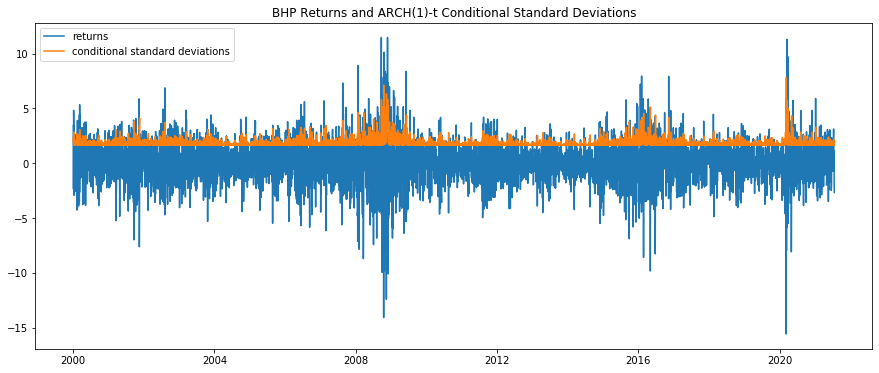

In [13]:
## A common way to show conditional standard deviations plotted on top of the actual returns.

fig = plt.figure(figsize=(15, 6))
plt.plot(r, label = 'returns')
plt.plot(s, label = 'conditional standard deviations')
plt.title('BHP Returns and ARCH(1)-t Conditional Standard Deviations')
plt.legend();

#### (d) Assess the fit of the ARCH(1)-t model using ACF plots and Ljung-Box tests, and a histogram/qqplot together with the Jarque-Bera test.

In [14]:
#Estimated error kurtosis
df1 = arch1t_fit.params['nu']
3*(df1-2)/(df1-4)

5.834250623645438

In [15]:
# Form the Student-t residuals, then transform to Gaussian residuals
e1 = arch1t_fit.std_resid
u1 = stats.t.cdf(np.sqrt(df1 / (df1 - 2)) * e1, df1)
e = stats.norm.ppf(u1)

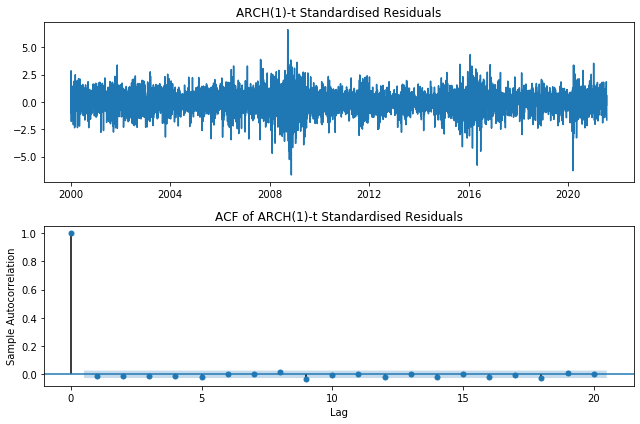

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(9, 6))

ax[0].plot(arch1t_fit.std_resid)
ax[0].set_title('ARCH(1)-t Standardised Residuals')

sm.graphics.tsa.plot_acf(e, ax=ax[1], lags=20, alpha=0.05)
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('Sample Autocorrelation')
ax[1].set_title('ACF of ARCH(1)-t Standardised Residuals')

plt.tight_layout()
plt.show()

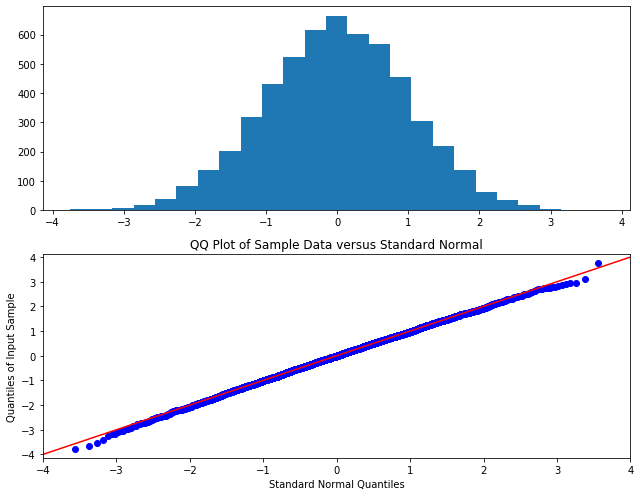

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(9, 7))

ax[0].hist(e, bins=25)

sm.qqplot(e, ax=ax[1], line='45')
ax[1].set_xlim(-4, 4)
ax[1].set_xlabel('Standard Normal Quantiles')
ax[1].set_ylabel('Quantiles of Input Sample')
ax[1].set_title('QQ Plot of Sample Data versus Standard Normal')

plt.tight_layout()
plt.show()

When we do the qq-plots we need to becareful what we are plotting. In this model, we are assuming a student-t's distribution. Specifically, we assume

$$r_t=\mu_t + \varepsilon_t,\quad\textrm{where } \varepsilon_t\sim \sqrt{\frac{\nu-2}{\nu}}\times t_\nu(0, \sigma_t^2)=\ t_\nu\left(0, \left(\frac{\nu-2}{\nu}\right)\sigma_t^2\right)$$

So when we plot the standardized residual
$$\frac{\varepsilon_t}{\sigma_t}\sim \sqrt{\frac{\nu-2}{\nu}}\times t_\nu(0,1)$$
Meaning it is distributed like a student's-t distribution not a normal distribution. But, a qq-plot is comparing it to a normal distribution not a student's-t distribution.

So what we need to do, in order for the qq-plot to work, is that we need to covert the standardized returns into a normal distribution.

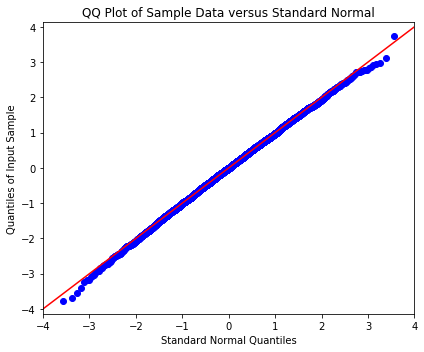

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

# Form the Student-t residuals, then transform to Gaussian residuals
e1 = arch1t_fit.std_resid
u1 = stats.t.cdf(np.sqrt(df1 / (df1 - 2)) * e1, df1)
e = stats.norm.ppf(u1)

sm.qqplot(e, ax=ax, line='45')
ax.set_xlim(-4, 4)
ax.set_xlabel('Standard Normal Quantiles')
ax.set_ylabel('Quantiles of Input Sample')
ax.set_title('QQ Plot of Sample Data versus Standard Normal')

plt.tight_layout()
plt.show()

In [19]:
jb, pval, skew, kurt = jarque_bera(e)
jb_tbl = pd.DataFrame(np.array([jb, pval, skew, kurt]).round(3))
jb_tbl.index = ['JB-stat', 'P-Value', 'Skewness', 'Kurtosis']
jb_tbl.columns = ['']
jb_tbl

,
JB-stat,5.699
P-Value,0.058
Skewness,-0.079
Kurtosis,2.992


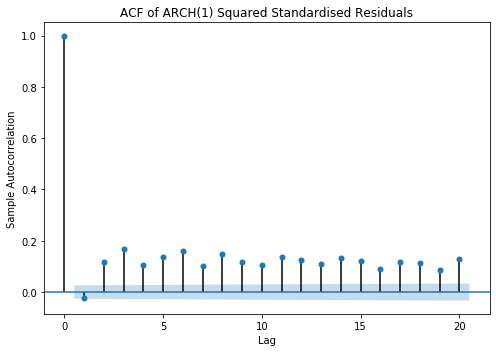

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sm.graphics.tsa.plot_acf(e**2, lags=20, alpha=0.05, ax=ax)
plt.xlabel('Lag')
plt.ylabel('Sample Autocorrelation')
plt.title('ACF of ARCH(1) Squared Standardised Residuals')
plt.tight_layout()
plt.show()

In [21]:
acorr_ljungbox(e, lags=5, model_df=2, return_df=True).iloc[-1]

lb_stat      5.775247
lb_pvalue    0.123072
Name: 5, dtype: float64

In [22]:
acorr_ljungbox(e, lags=10, model_df=2, return_df=True).iloc[-1]

lb_stat      12.399655
lb_pvalue     0.134243
Name: 10, dtype: float64

In [23]:
# Null Hypothesis - The data are independently distributed

acorr_ljungbox(e ** 2, lags=5, model_df=2, return_df=True).iloc[-1]

lb_stat      3.967466e+02
lb_pvalue    1.121678e-85
Name: 5, dtype: float64

In [24]:
acorr_ljungbox(e ** 2, lags=10, model_df=2, return_df=True).iloc[-1]

lb_stat       8.508019e+02
lb_pvalue    2.301615e-178
Name: 10, dtype: float64

In [25]:
# Null Hypothesis - A series of residuals (rt) exhibits no conditional heteroscedasticity (ARCH effects)

arch_stat, pval = het_arch(e, nlags=5)[:2]
print(arch_stat)
print(pval)

366.12990428368175
5.8847322399648536e-77


In [26]:
arch_stat, pval = het_arch(e, nlags=10)[:2]
print(arch_stat)
print(pval)

546.236428578796
5.725874271125538e-111


### Answer guide
The ACF of the transformed residuals seems to show a general lack of autocorrelation in the residuals at all lags. This is confirmed by the Ljung-Box (LB) tests, using 5 and 10 lags, i.e. 3 and 8 degrees of freedom; i.e. 5-2 =3, 10-2 = 8; 2 is from the ARCH(1) effect and the dof from the Student-t. Both LB tests have p-val $>0.05$, indicating that no significant autocrrelations exist in the first 5 or 10 lags of the residuals. Thus, the constant mean fits the data well. 

The ACF of the squared transformed residuals shows generally strong ARCH effects in the residuals at all lags except lag 1. It seems the ARCH(1) has accounted for the lag 1 ARCH effect, but at no other lags. This is confirmed by the Ljung-Box (LB) tests, using 5 and 10 lags, i.e. 3 and 8 degrees of freedom, which have p-vals $\approx 0$, indicating statistically significant ARCH effects remain in the first 5 or 10 lags of the residuals. Thus, the ARCH(1) volatility equation does not fit the data well and can be rejected.

Finally, the Histogram and QQ-plot for the transformed residuals show apparent distribution close to normality or Gaussian, whilst the sample skewness and kurtosis are very close to 0 and 3 respectively. The JB test confirms this with p-value $>0.05$, indicating that we cannot reject normality for the transformed residuals and hence the standardised Student-t fits the conditional BH return distribution well. 

The next section attempts to improve the volatility equation. 

#### (e) Use the AIC and SIC functions to identify a suitable ARCH(p)-t model order for the BHP return data.

In [27]:
aic = np.empty(20)
bic = np.empty(20)

for i in range(20):
    arch = arch_model(r, mean='Constant', vol='ARCH', dist='StudentsT', p=(i + 1))
    fit = arch.fit(disp="off")
    aic[i] = fit.aic
    bic[i] = fit.bic

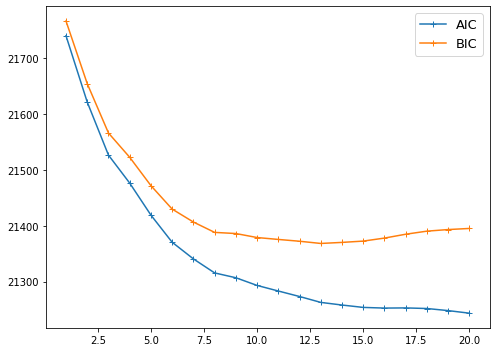

In [28]:
p = np.arange(1, 21)
plt.figure(figsize=(7, 5))
plt.plot(p, aic, '-+', label='AIC')
plt.plot(p, bic, '-+', label='BIC')
plt.legend(fontsize=13)
plt.tight_layout()
plt.show()

In [29]:
tbl_ic = pd.DataFrame({'AIC': aic.round(0), 'BIC': bic.round(0)}, index=p)
tbl_ic.index.name = 'p'

tbl_ic.T

p,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
AIC,21741.0,21622.0,21527.0,21476.0,21419.0,21370.0,21341.0,21315.0,21307.0,21293.0,21283.0,21273.0,21263.0,21258.0,21254.0,21252.0,21253.0,21252.0,21248.0,21243.0
BIC,21767.0,21655.0,21566.0,21523.0,21472.0,21430.0,21407.0,21388.0,21386.0,21379.0,21375.0,21372.0,21368.0,21370.0,21373.0,21378.0,21385.0,21390.0,21393.0,21395.0


In [30]:
np.argmin(aic) + 1

20

In [31]:
np.argmin(bic) + 1

13

### Answer guide
The AIC suggests $p=20$, while the SIC suggests $p=13$. Based on choosing a parsimonious model, $p=13$ is chosen.

#### (f) Fit the constant mean ARCH(p)-t model with lag order chosen in part (e). What is the fitted model? Are all chosen ARCH lags significant?

In [32]:
arch13 = arch_model(r, mean='Constant', vol='ARCH', dist='StudentsT', p=13)
arch13_fit = arch13.fit(disp="off")
print(arch13_fit.summary())

                         Constant Mean - ARCH Model Results                         
Dep. Variable:                    Adj Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             ARCH   Log-Likelihood:               -10615.3
Distribution:      Standardized Student's t   AIC:                           21262.6
Method:                  Maximum Likelihood   BIC:                           21368.3
                                              No. Observations:                 5450
Date:                      Fri, Oct 15 2021   Df Residuals:                     5449
Time:                              12:01:49   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

### Answer guide 
The fitted model is:
    
$\sigma_t^2 = 0.84 + 0.078 a_{t-1}^2 + 0.050 a_{t-2}^2 + 0.088 a_{t-3}^2 + 0.047 a_{t-4}^2 + 0.077 a_{t-5}^2 + 0.079 a_{t-6}^2 + 0.065 a_{t-7}^2 + 0.051 a_{t-8}^2 + 0.034 a_{t-9}^2 + 0.045 a_{t-10}^2 + 0.043 a_{t-11}^2 + 0.053 a_{t-12}^2 + 0.056 a_{t-13}^2$

whilst the degrees of freedom estimate is 11.51 and the mean BHP return is estimated as 0.081.

All ARCH effects at lags 1-13 are statistically significant, with pvalues $<0.05$ (the minimum is 0.035) and 0 is not included in their respective 95% confidence intervals.  


#### (g) Compare the estimated volatility with that of the ARCH(1). How and why are they different?

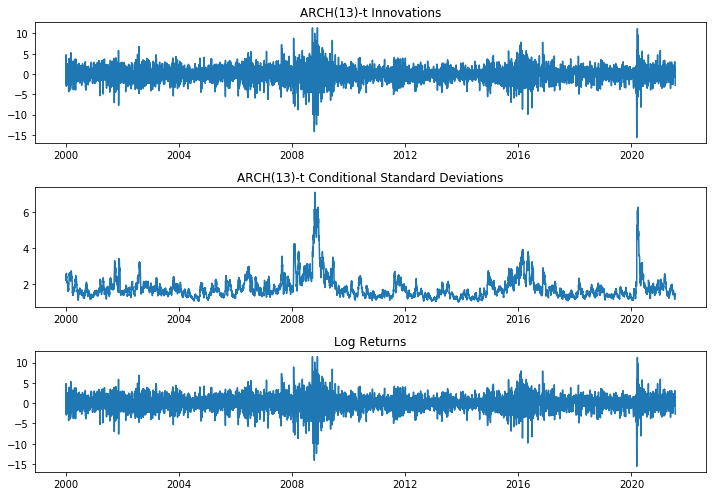

In [33]:
a13 = arch13_fit.resid
s13 = arch13_fit.conditional_volatility
fig, ax = plt.subplots(3, 1, figsize=(10, 7))

ax[0].plot(a13)
ax[0].set_title('ARCH(13)-t Innovations')

ax[1].plot(s13)
ax[1].set_title('ARCH(13)-t Conditional Standard Deviations')

ax[2].plot(r)
ax[2].set_title('Log Returns')
plt.tight_layout()
plt.show()

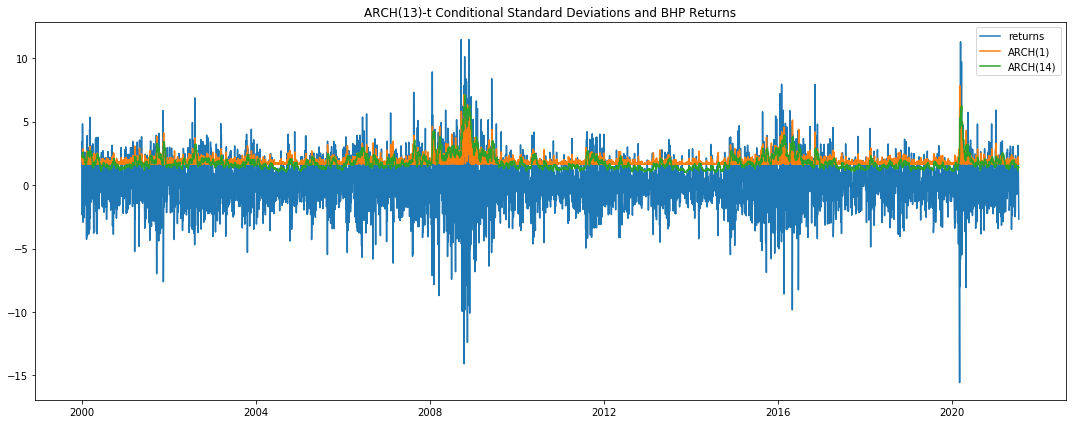

In [34]:
plt.figure(figsize=(15, 6))
plt.plot(r, label='returns')
plt.plot(s, label='ARCH(1)')
plt.plot(s13, label='ARCH(14)')
plt.title('ARCH(13)-t Conditional Standard Deviations and BHP Returns')
plt.legend()
plt.tight_layout()
plt.show()

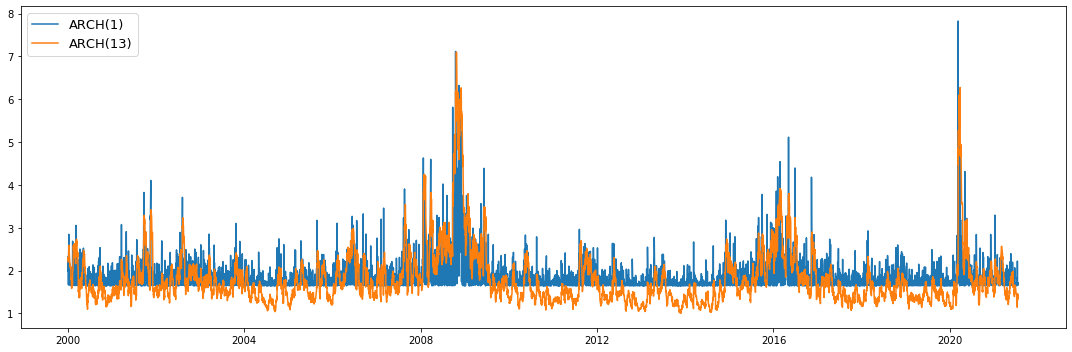

In [35]:
plt.figure(figsize=(15, 5))
plt.plot(s, label='ARCH(1)')
plt.plot(s13, label='ARCH(13)')
plt.legend(fontsize=13)
plt.tight_layout()
plt.show()

### Answer guide
The ARCH(13) gives a much smoother estimated volatility process than the ARCH(1) model. It also does not hit, or get very close to, its lower limit ($\alpha_0$), whereas the ARCH(1) volatility does, often. Finally, the ARCH(13) tends to give mostly lower estimates of volatility at high volatility periods, likely following large return shocks; i.e. it does not react as strongly to large shocks as the ARCH(1) model does. 

#### (h) Assess the fit of the ARCH(p)-t model in (g) using ACF plots, Ljung-Box and ARCH tests and a histogram/qqplot together with the Jarque-Bera test. Has the fit improved from the ARCH(1)-t?

In [36]:
#Estimated error kurtosis
df13 = arch13_fit.params['nu']
3*(df13-2)/(df13-4)

3.7989004776722433

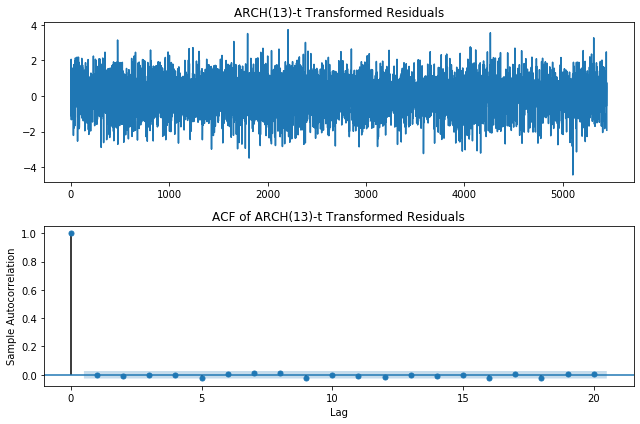

In [37]:
e13_t = arch13_fit.std_resid
u13 = stats.t.cdf(np.sqrt(df13 / (df13 - 2)) * e13_t, df13)
e13 = stats.norm.ppf(u13)

fig, ax = plt.subplots(2, 1, figsize=(9, 6))

ax[0].plot(e13)
ax[0].set_title('ARCH(13)-t Transformed Residuals')

sm.graphics.tsa.plot_acf(e13, ax=ax[1], lags=20, alpha=0.05)
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('Sample Autocorrelation')
ax[1].set_title('ACF of ARCH(13)-t Transformed Residuals')
plt.tight_layout()
plt.show()

In [38]:
# Remaining AR effects
acorr_ljungbox(e13, lags=17, model_df=14, return_df=True).iloc[-1]

lb_stat      13.377836
lb_pvalue     0.003887
Name: 17, dtype: float64

In [39]:
acorr_ljungbox(e13, lags=22, model_df=14, return_df=True).iloc[-1]

lb_stat      17.331643
lb_pvalue     0.026835
Name: 22, dtype: float64

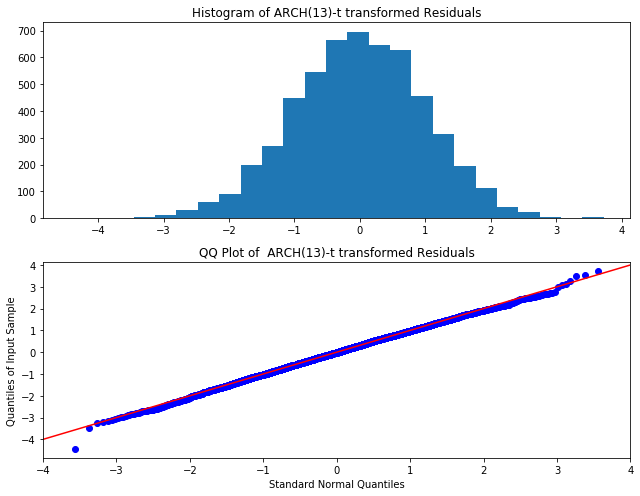

In [40]:
fig, ax = plt.subplots(2, 1, figsize=(9, 7))

ax[0].hist(e13, bins=25)
ax[0].set_title('Histogram of ARCH(13)-t transformed Residuals')


sm.qqplot(e13, ax=ax[1], line='45')
ax[1].set_xlim(-4, 4)
ax[1].set_xlabel('Standard Normal Quantiles')
ax[1].set_ylabel('Quantiles of Input Sample')
ax[1].set_title('QQ Plot of  ARCH(13)-t transformed Residuals')

plt.tight_layout()
plt.show()

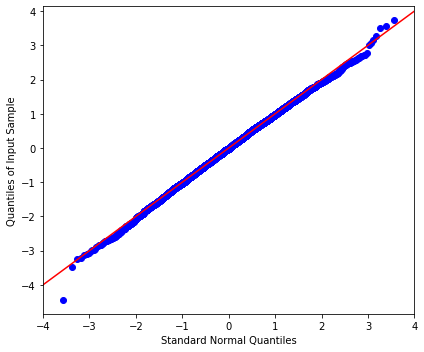

In [41]:
e13_t = arch13_fit.std_resid

u13 = stats.t.cdf(np.sqrt(df13 / (df13 - 2)) * e13_t, df13)
e13 = stats.norm.ppf(u13)

fig, ax = plt.subplots(1, 1, figsize=(6, 5))

sm.qqplot(e13, ax=ax, line='45')
ax.set_xlim(-4, 4)
ax.set_xlabel('Standard Normal Quantiles')
ax.set_ylabel('Quantiles of Input Sample')
# ax.set_title('QQ Plot of  ARCH(13)-t transformed Residuals')

plt.tight_layout()
plt.show()

In [42]:
jb, pval, skew, kurt = jarque_bera(e13)
jb_tbl = pd.DataFrame(np.array([jb, pval, skew, kurt]).round(3))
jb_tbl.index = ['JB-stat', 'P-Value', 'Skewness', 'Kurtosis']
jb_tbl.columns = ['']
jb_tbl

,
JB-stat,7.708
P-Value,0.021
Skewness,-0.092
Kurtosis,3.005


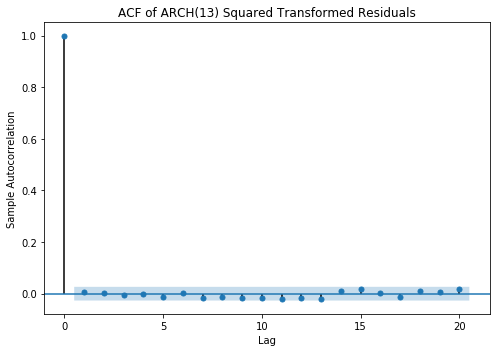

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sm.graphics.tsa.plot_acf(e13**2, lags=20, alpha=0.05, ax=ax)
plt.xlabel('Lag')
plt.ylabel('Sample Autocorrelation')
plt.title('ACF of ARCH(13) Squared Transformed Residuals')
plt.tight_layout()
plt.show()

In [44]:
acorr_ljungbox(e13**2, lags=17, model_df=14, return_df=True).iloc[-1]

lb_stat      15.465832
lb_pvalue     0.001459
Name: 17, dtype: float64

In [45]:
# Remianing ARCH effects
acorr_ljungbox(e13**2, lags=22, model_df=14, return_df=True).iloc[-1]

lb_stat      18.370681
lb_pvalue     0.018613
Name: 22, dtype: float64

### Answer guide
The ACF of the transformed residuals from the ARCH(13)-t model seems to show a general lack of autocorrelation in the residuals at all lags. This, however, is not confirmed by the Ljung-Box (LB) tests, using 17 and 22 lags, i.e. 3 and 8 degrees of freedom; i.e. 14 dof is from the ARCH(13) effects plus the dof from the Student-t. Both LB tests have p-val $<0.05$, indicating that significant autocrrelations exist in the first 17 or 22 lags of the residuals. Thus, the constant mean no longer fits the data well and can be rejected. 

The ACF of the squared transformed residuals shows generally strong ARCH effects in the residuals at all lags except lag 1. It seems the ARCH(1) has accounted for the lag 1 ARCH effect, but at no other lags. This is confirmed by the Ljung-Box (LB) tests, using 17 and 22 lags, i.e. 3 and 8 degrees of freedom, which have p-vals $<0.05$, indicating statistically significant ARCH effects remain in the first 17 or 22 lags of the transformed residuals from the ARCH(13)-t model. Thus, the ARCH(13) volatility equation does not fit the data well and can be rejected.

Finally, the Histogram and QQ-plot for the transformed residuals show apparent distribution close to normality or Gaussian, whilst the sample skewness and kurtosis are very close to 0 and 3 respectively. However, the JB test does not confirm this, with p-value $<0.05$, indicating that we can reject normality for the transformed residuals and hence reject the standardised Student-t which does not the conditional BH return distribution well. It seems this results is driven by the skewness of $-0.09$ being significantly below 0, which seems mostly affected by the single negative outlier apparent in the QQ-plot.  

The next section attempts to improve both the mean and volatility equations. 

#### i) Fit an AR(1)-GARCH(1,1)-t model to the log-return series. Did you find a significant AR effect? Compare the estimated volatility series to those for the 2 ARCH models above.

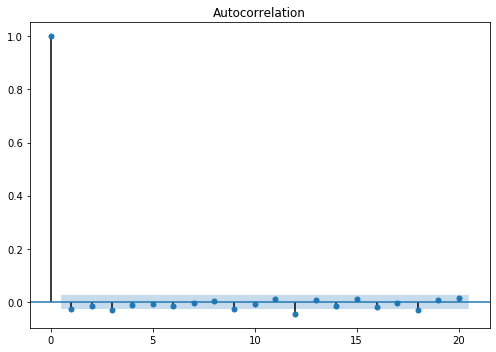

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sm.graphics.tsa.plot_acf(r, lags=20, alpha=0.05, ax=ax)
plt.tight_layout()
plt.show()

In [47]:
ar1_garch1t = arch_model(r, mean='AR', lags=1, vol='GARCH', p=1, q=1, dist='StudentsT')
ar1_garch1t_fit = ar1_garch1t.fit(disp="off")
print(ar1_garch1t_fit.summary())

                              AR - GARCH Model Results                              
Dep. Variable:                    Adj Close   R-squared:                       0.000
Mean Model:                              AR   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -10583.5
Distribution:      Standardized Student's t   AIC:                           21178.9
Method:                  Maximum Likelihood   BIC:                           21218.6
                                              No. Observations:                 5449
Date:                      Fri, Oct 15 2021   Df Residuals:                     5447
Time:                              12:01:51   Df Model:                            2
                                   Mean Model                                  
                   coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------------

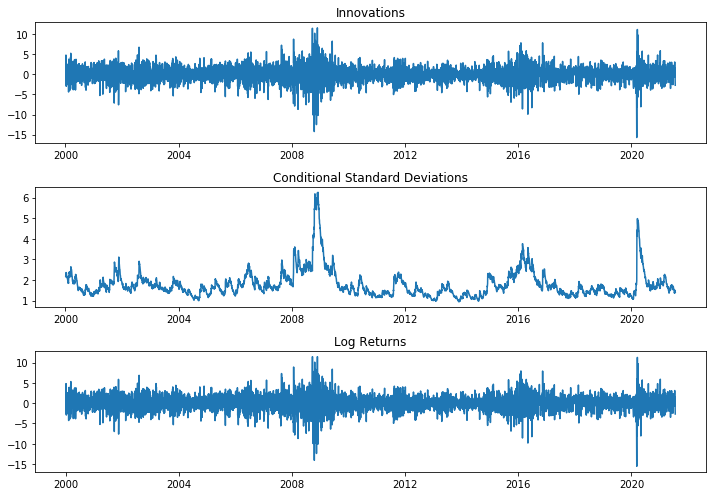

In [48]:
agt = ar1_garch1t_fit.resid
sgt = ar1_garch1t_fit.conditional_volatility
fig, ax = plt.subplots(3, 1, figsize=(10, 7))

ax[0].plot(agt)
ax[0].set_title('Innovations')

ax[1].plot(sgt)
ax[1].set_title('Conditional Standard Deviations')
ax[2].plot(r)
ax[2].set_title('Log Returns')
plt.tight_layout()
plt.show()

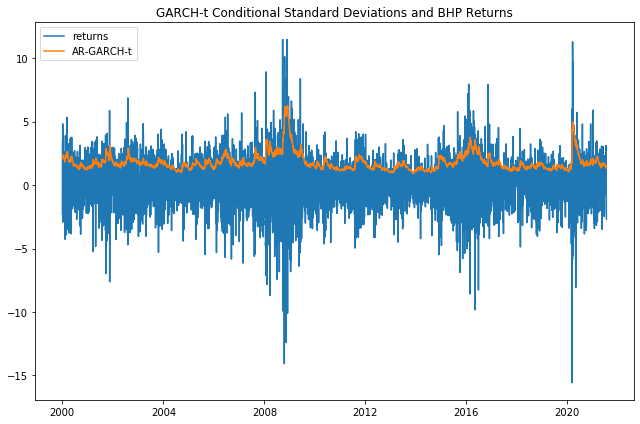

In [49]:
plt.figure(figsize=(9, 6))
plt.plot(r, label = 'returns')
plt.plot(sgt, label = 'AR-GARCH-t')
plt.title('GARCH-t Conditional Standard Deviations and BHP Returns')
plt.legend()
plt.tight_layout()
plt.show()

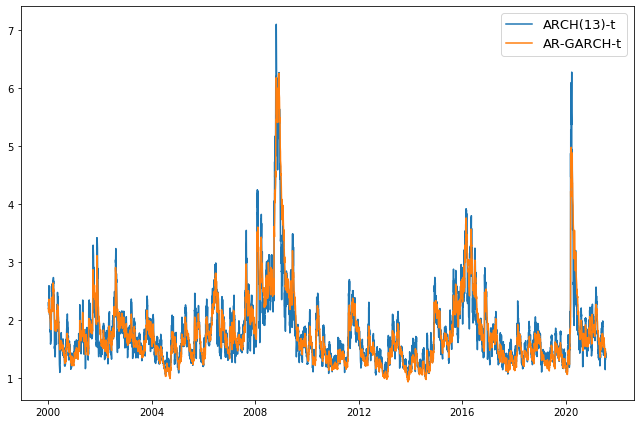

In [50]:
plt.figure(figsize=(9, 6))
plt.plot(s13, label='ARCH(13)-t')
plt.plot(sgt, label='AR-GARCH-t')
plt.legend(fontsize=13)
plt.tight_layout()
plt.show()

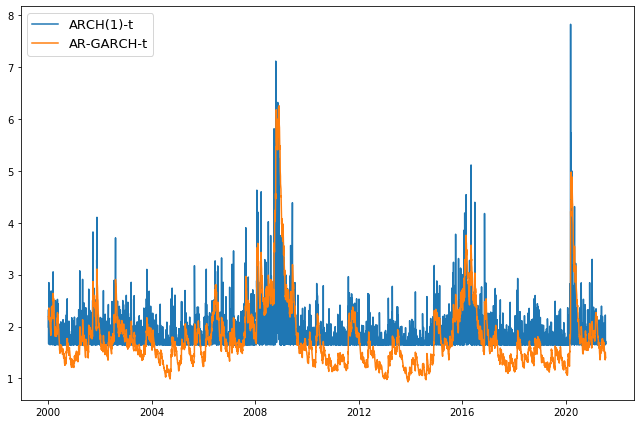

In [51]:
plt.figure(figsize=(9, 6))
plt.plot(s, label='ARCH(1)-t')
plt.plot(sgt, label='AR-GARCH-t')
plt.legend(fontsize=13)
plt.tight_layout()
plt.show()

### Answer guide
The AR(1) parameter is not significantly different to 0, with p-value $=0.19 >0.05$. 

The GARCH model estimates a volatility series that is the most smooth among the three models used so far. As the ARCH(13) reacted less strongly to large return shocks than the ARCH(1), so also the GARCH volatility estimates react less strongly to large return shocks than the ARCH(13) (and hence also the ARCH(1)). 

### (j)  Assess the fit of the AR-GARCH-t model

In [52]:
#Estimated error kurtosis
dfg = ar1_garch1t_fit.params['nu']
3*(dfg-2)/(dfg-4)

3.7587292602845728

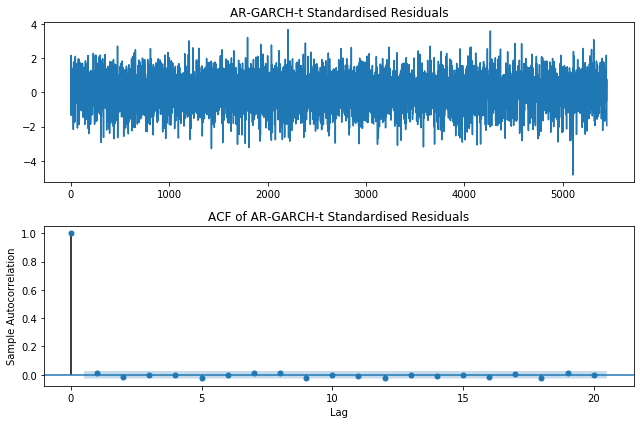

In [53]:
eg_t = ar1_garch1t_fit.std_resid
ug = stats.t.cdf(np.sqrt(dfg / (dfg - 2)) * eg_t[1:], dfg)
eg = stats.norm.ppf(ug)

fig, ax = plt.subplots(2, 1, figsize=(9, 6))
ax[0].plot(eg)
sm.graphics.tsa.plot_acf(eg, ax=ax[1], lags=20, alpha=0.05)
ax[0].set_title('AR-GARCH-t Standardised Residuals')
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('Sample Autocorrelation')
ax[1].set_title('ACF of AR-GARCH-t Standardised Residuals')
plt.tight_layout()
plt.show()

In [54]:
sum(ug>0), len(ug)

(5449, 5449)

In [55]:
ug

array([0.12981477, 0.60222722, 0.98420896, ..., 0.77881356, 0.67382618,
       0.02655542])

In [56]:
eg_t    # the 1st residual is given as 'nan', which means not a number. I encourage students to investigate why this occurred, but note that I simply delete it to proceed  for now.

Date
2000-01-04         NaN
2000-01-05   -1.079715
2000-01-06    0.241718
2000-01-07    2.221170
2000-01-10    0.331052
                ...   
2021-07-13   -0.469921
2021-07-14    0.286606
2021-07-15    0.724843
2021-07-16    0.421499
2021-07-19   -1.958277
Name: std_resid, Length: 5450, dtype: float64

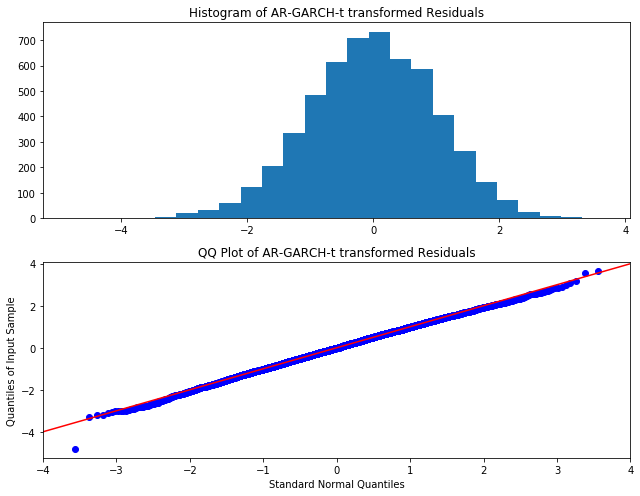

In [57]:
fig, ax = plt.subplots(2, 1, figsize=(9, 7))
ax[0].hist(eg, bins=25)
ax[0].set_title('Histogram of AR-GARCH-t transformed Residuals')
sm.qqplot(eg, ax=ax[1], line='45')
ax[1].set_xlim(-4, 4)
ax[1].set_xlabel('Standard Normal Quantiles')
ax[1].set_ylabel('Quantiles of Input Sample')
ax[1].set_title('QQ Plot of AR-GARCH-t transformed Residuals')
plt.tight_layout()
plt.show()

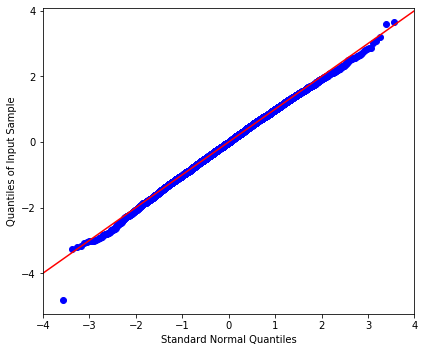

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

sm.qqplot(eg, ax=ax, line='45')
ax.set_xlim(-4, 4)
ax.set_xlabel('Standard Normal Quantiles')
ax.set_ylabel('Quantiles of Input Sample')
# ax.set_title('QQ Plot of  ARCH(13)-t transformed Residuals')

plt.tight_layout()
plt.show()

In [59]:
jb, pval, skew, kurt = jarque_bera(eg)
jb_tbl = pd.DataFrame(np.array([jb, pval, skew, kurt]).round(3))
jb_tbl.index = ['JB-stat', 'P-Value', 'Skewness', 'Kurtosis']
jb_tbl.columns = ['']
jb_tbl

,
JB-stat,11.604
P-Value,0.003
Skewness,-0.113
Kurtosis,3.014


In [60]:
# Null Hypothesis - The data are independently distributed
acorr_ljungbox(eg, lags=7, model_df=4, return_df=True).iloc[-1]

lb_stat      5.129375
lb_pvalue    0.162565
Name: 7, dtype: float64

In [61]:
acorr_ljungbox(eg, lags=12, model_df=4, return_df=True).iloc[-1]

lb_stat      11.221023
lb_pvalue     0.189487
Name: 12, dtype: float64

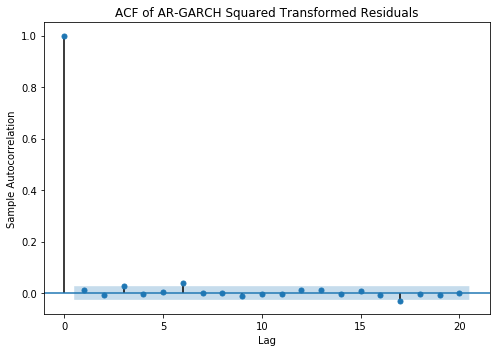

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sm.graphics.tsa.plot_acf(eg**2, lags=20, alpha=0.05, ax=ax)
plt.xlabel('Lag')
plt.ylabel('Sample Autocorrelation')
plt.title('ACF of AR-GARCH Squared Transformed Residuals')
plt.tight_layout()
plt.show()

In [63]:
# Null Hypothesis - The data are independently distributed

acorr_ljungbox(eg ** 2, lags=7, model_df=4, return_df=True).iloc[-1]

lb_stat      12.992313
lb_pvalue     0.004653
Name: 7, dtype: float64

In [64]:
acorr_ljungbox(eg ** 2, lags=12, model_df=4, return_df=True).iloc[-1]

lb_stat      14.598314
lb_pvalue     0.067443
Name: 12, dtype: float64

### Answer guide
The ACF of the transformed residuals from the AR-GARCH-t model once again shows a general lack of autocorrelation in the residuals at all lags. This is confirmed by the Ljung-Box (LB) tests, using 7 and 12 lags, i.e. 3 and 8 degrees of freedom; i.e. 4 dof is from the 1 AR(1) effect, plus the 2 GARCH(1,1) effects plus the dof from the Student-t. Both LB tests have p-val $>0.05$, indicating that no significant autocrrelation exists in the first 7 or 12 lags of the residuals. Thus, the AR(1) mean equation fits the data well and cannot be rejected. 

The ACF of the squared transformed residuals shows a couple of moderate ARCH effects in the residuals, only at lags 3 and 6.  The Ljung-Box (LB) tests, using 7 and 12 lags, i.e. 3 and 8 degrees of freedom, disagree with each other here. The test using 7 lags has p-value $=0.005 <0.05$, indicating statistically significant ARCH effects remain in the first 7 lags of the transformed residuals from the AR-GARCH-t model. However, he test using 12 lags has p-value $=0.067 > 0.05$, indicating no statistically significant ARCH effects remain in the first 12 lags of the transformed residuals from the AR-GARCH-t model. Thus, it is unclear what the tests suggest about the volatility equation of the AR-GARCH-t model. 

Finally, the Histogram and QQ-plot for the transformed residuals show an apparent distribution close to normality or Gaussian, except for a single negative outlier in the QQ-plot. Whilst the sample skewness and kurtosis are very close to 0 and 3 respectively, again the JB test does not confirm this, with p-value $= 0.003 <0.05$, indicating that we can reject normality for the transformed residuals and hence reject the standardised Student-t which does not the conditional BH return distribution well. Again this result seems driven by the skewness of $-0.11$ being significantly below 0, which seems mostly affected by the single negative outlier apparent in the QQ-plot.  

It seems clear that the GARCH is closest to an adequate volatility equation of the model considered so far. Next week, we will see if we can improve it by considering p,q >1 and also asymmetric GARCH models.

In [91]:
n = 5

AIC = pd.DataFrame(0.0, columns=np.arange(1, n + 1), index=np.arange(1, n + 1))
BIC = pd.DataFrame(0.0, columns=np.arange(1, n + 1), index=np.arange(1, n + 1))

for p in range(1, n + 1):
    for q in range(1, n + 1):
        model = arch_model(r, mean='AR', lags=1, vol='GARCH', p=p, q=q, dist='StudentsT')
        result = model.fit(disp="off")
        
        AIC.loc[p, q] = result.aic
        BIC.loc[p, q] = result.bic

In [92]:
AIC.columns.name = 'q'
AIC.index.name = 'p'

AIC

q,1,2,3,4,5
p,,,,,
1,21178.941435,21179.809018,21181.809019,21183.809019,21185.809018
2,21180.941434,21181.174581,21183.174581,21185.174582,21187.171816
3,21182.728533,21182.023321,21182.677153,21184.673156,21186.168169
4,21184.728533,21184.023321,21184.677153,21186.673156,21188.160828
5,21186.728533,21186.023321,21186.677153,21188.673156,21188.829171


In [93]:
BIC.columns.name = 'q'
BIC.index.name = 'p'

BIC

q,1,2,3,4,5
p,,,,,
1,21218.560559,21226.031330,21234.634518,21243.237705,21251.840892
2,21227.163746,21234.000080,21242.603268,21251.206455,21259.806877
3,21235.554032,21241.452007,21248.709027,21257.308217,21265.406417
4,21244.157219,21250.055195,21257.312214,21265.911405,21274.002264
5,21252.760407,21258.658382,21265.915401,21274.514592,21281.273794
